## Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import pickle

from scipy.sparse import csr_matrix
import torch
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors

## Data Cleaning

### BX-Books.csv

In [3]:
# Import BOOKS dataset
books = pd.read_csv("dataset/BX-Books.csv", sep=";", on_bad_lines='skip', encoding='latin-1')

C:\Users\User\AppData\Local\Temp\ipykernel_24148\4155831314.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books = pd.read_csv("dataset/BX-Books.csv", sep=";", on_bad_lines='skip', encoding='latin-1')


In [4]:
# View data
books.head(5)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [5]:
# Check data amount (270k)
books.shape

(271360, 8)

In [6]:
# Check for null values
round(books.isna().sum() * 100 / len(books), 2)

ISBN                   0.0
Book-Title             0.0
Book-Author            0.0
Year-Of-Publication    0.0
Publisher              0.0
Image-URL-S            0.0
Image-URL-M            0.0
Image-URL-L            0.0
dtype: float64

In [7]:
# Check for duplicates
books.duplicated().sum()

0

In [8]:
books.columns

Index(['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher',
       'Image-URL-S', 'Image-URL-M', 'Image-URL-L'],
      dtype='object')

In [9]:
# Drop irrelevant columns (redundant book cover image columns)
books = books[['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher',
       'Image-URL-L']]

In [10]:
books.isna().sum()

ISBN                   0
Book-Title             0
Book-Author            1
Year-Of-Publication    0
Publisher              2
Image-URL-L            3
dtype: int64

In [11]:
# Because the null values are miniscule, we will drop it
books.dropna(inplace=True)

In [12]:
# Check if it was dropped it successfuly
books.isna().sum()

ISBN                   0
Book-Title             0
Book-Author            0
Year-Of-Publication    0
Publisher              0
Image-URL-L            0
dtype: int64

In [13]:
books

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...
...,...,...,...,...,...,...
271355,0440400988,There's a Bat in Bunk Five,Paula Danziger,1988,Random House Childrens Pub (Mm),http://images.amazon.com/images/P/0440400988.0...
271356,0525447644,From One to One Hundred,Teri Sloat,1991,Dutton Books,http://images.amazon.com/images/P/0525447644.0...
271357,006008667X,Lily Dale : The True Story of the Town that Ta...,Christine Wicker,2004,HarperSanFrancisco,http://images.amazon.com/images/P/006008667X.0...
271358,0192126040,Republic (World's Classics),Plato,1996,Oxford University Press,http://images.amazon.com/images/P/0192126040.0...


In [14]:
# Rename the columns for convenience

books.rename(columns={
    'Book-Title' : 'title',
    'Book-Author' : 'author',
    'Year-of-Publication' : 'year',
    'Publisher' : 'publisher',
    'Image-URL-L' : 'image',
}, inplace=True)

In [15]:
books

,ISBN,title,author,Year-Of-Publication,publisher,image
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...
...,...,...,...,...,...,...
271355,0440400988,There's a Bat in Bunk Five,Paula Danziger,1988,Random House Childrens Pub (Mm),http://images.amazon.com/images/P/0440400988.0...
271356,0525447644,From One to One Hundred,Teri Sloat,1991,Dutton Books,http://images.amazon.com/images/P/0525447644.0...
271357,006008667X,Lily Dale : The True Story of the Town that Ta...,Christine Wicker,2004,HarperSanFrancisco,http://images.amazon.com/images/P/006008667X.0...
271358,0192126040,Republic (World's Classics),Plato,1996,Oxford University Press,http://images.amazon.com/images/P/0192126040.0...


### BX-Users.csv

In [16]:
# Import USERS dataset
users = pd.read_csv("dataset/BX-Users.csv", sep=";", on_bad_lines='skip', encoding='latin-1')

In [17]:
# View data
users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [18]:
# Check for null values percentage
round(users.isna().sum() * 100 / len(users))

User-ID      0.0
Location     0.0
Age         40.0
dtype: float64

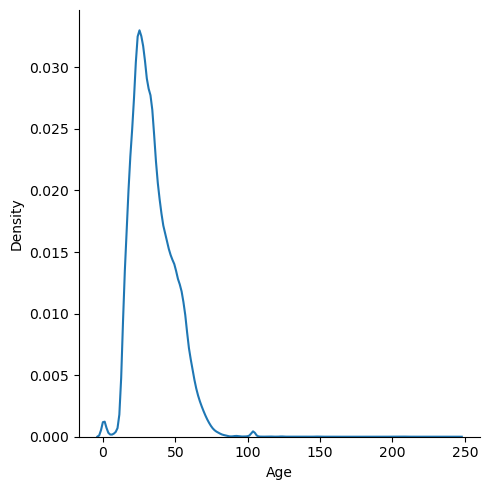

In [19]:
# Since the missing data is still less than 50%, we will handle by imputing
# And since the distribution is skewed, we will impute by median
sns.displot(x='Age', data=users, kind='kde')

In [20]:
users['Age'].fillna(users['Age'].median(), inplace=True)

In [21]:
# Check if the missing values has been imputed successfuly
round(users.isna().sum() * 100 / len(users))

User-ID     0.0
Location    0.0
Age         0.0
dtype: float64

In [22]:
# Check for duplicates
users.duplicated().sum()

0

### BX-Book-Ratings.csv

In [23]:
# Import RATINGS dataset
ratings = pd.read_csv("dataset/BX-Book-Ratings.csv", sep=";", on_bad_lines="skip", encoding="latin-1")

In [24]:
# View data
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [25]:
# Check data amount (1.1M)
ratings.shape

(1149780, 3)

In [26]:
print(books.shape)
print(users.shape)
print(ratings.shape)

(271354, 6)
(278858, 3)
(1149780, 3)


In [27]:
# Rename the columns for convenience

ratings.rename(columns={
    "User-ID" : "user_id",
    "Book-Rating" : "rating"
}, inplace=True)

In [28]:
ratings

,user_id,ISBN,rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6
...,...,...,...
1149775,276704,1563526298,9
1149776,276706,0679447156,0
1149777,276709,0515107662,10
1149778,276721,0590442449,10


In [29]:
# Check for null values
round(ratings.isna().sum() * 100 / len(ratings))

user_id    0.0
ISBN       0.0
rating     0.0
dtype: float64

In [30]:
# Check for duplicates
ratings.duplicated().sum()

0

## Preprocessing

### User Rating Based Similarity

In [31]:
# Filter for users with more than 200 ratings
x = ratings['user_id'].value_counts() > 200

In [32]:
# There are 899 users
x[x].shape

(899,)

In [33]:
y = x[x].index
ratings_filtered = ratings[ratings['user_id'].isin(y)]

In [34]:
ratings_filtered.head()

,user_id,ISBN,rating
1456,277427,002542730X,10
1457,277427,0026217457,0
1458,277427,003008685X,8
1459,277427,0030615321,0
1460,277427,0060002050,0


In [35]:
# There are 520k ratings data left
ratings_filtered.shape

(526356, 3)

In [36]:
# Merge with book data 
ratings_with_books = ratings_filtered.merge(books, on="ISBN")

In [37]:
ratings_with_books

,user_id,ISBN,rating,title,author,Year-Of-Publication,publisher,image
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994,John Wiley &amp; Sons Inc,http://images.amazon.com/images/P/002542730X.0...
1,3363,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994,John Wiley &amp; Sons Inc,http://images.amazon.com/images/P/002542730X.0...
2,11676,002542730X,6,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994,John Wiley &amp; Sons Inc,http://images.amazon.com/images/P/002542730X.0...
3,12538,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994,John Wiley &amp; Sons Inc,http://images.amazon.com/images/P/002542730X.0...
4,13552,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994,John Wiley &amp; Sons Inc,http://images.amazon.com/images/P/002542730X.0...
...,...,...,...,...,...,...,...,...
487661,275970,1892145022,0,Here Is New York,E. B. White,1999,Little Bookroom,http://images.amazon.com/images/P/1892145022.0...
487662,275970,1931868123,0,There's a Porcupine in My Outhouse: Misadventu...,Mike Tougias,2002,Capital Books (VA),http://images.amazon.com/images/P/1931868123.0...
487663,275970,3411086211,10,Die Biene.,Sybil GrÃ?Â¤fin SchÃ?Â¶nfeldt,1993,"Bibliographisches Institut, Mannheim",http://images.amazon.com/images/P/3411086211.0...
487664,275970,3829021860,0,The Penis Book,Joseph Cohen,1999,Konemann,http://images.amazon.com/images/P/3829021860.0...


In [38]:
# There are 160k books in ratings data
ratings_with_books['title'].nunique()

160265

In [39]:
# There are 487k ratings data left after merge 
# (there must've been significant amount of books without ISBN)
ratings_with_books.shape

(487666, 8)

In [40]:
# Calculate number of ratings for each book
num_rating = ratings_with_books.groupby('title')['rating'].count().reset_index()

In [41]:
num_rating

,title,rating
0,A Light in the Storm: The Civil War Diary of ...,2
1,Always Have Popsicles,1
2,Apple Magic (The Collector's series),1
3,Beyond IBM: Leadership Marketing and Finance ...,1
4,Clifford Visita El Hospital (Clifford El Gran...,1
...,...,...
160260,Ã?Â?ber die Pflicht zum Ungehorsam gegen den S...,3
160261,Ã?Â?lpiraten.,1
160262,Ã?Â?rger mit Produkt X. Roman.,1
160263,Ã?Â?stlich der Berge.,1


In [42]:
num_rating.rename(columns={'rating' : 'num_of_rating'}, inplace=True)

In [43]:
num_rating.head()

,title,num_of_rating
0,A Light in the Storm: The Civil War Diary of ...,2
1,Always Have Popsicles,1
2,Apple Magic (The Collector's series),1
3,Beyond IBM: Leadership Marketing and Finance ...,1
4,Clifford Visita El Hospital (Clifford El Gran...,1


In [44]:
# Add as new row: num_rating
final_rating = ratings_with_books.merge(num_rating, on='title')

In [45]:
final_rating

,user_id,ISBN,rating,title,author,Year-Of-Publication,publisher,image,num_of_rating
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994,John Wiley &amp; Sons Inc,http://images.amazon.com/images/P/002542730X.0...,82
1,3363,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994,John Wiley &amp; Sons Inc,http://images.amazon.com/images/P/002542730X.0...,82
2,11676,002542730X,6,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994,John Wiley &amp; Sons Inc,http://images.amazon.com/images/P/002542730X.0...,82
3,12538,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994,John Wiley &amp; Sons Inc,http://images.amazon.com/images/P/002542730X.0...,82
4,13552,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994,John Wiley &amp; Sons Inc,http://images.amazon.com/images/P/002542730X.0...,82
...,...,...,...,...,...,...,...,...,...
487661,275970,1892145022,0,Here Is New York,E. B. White,1999,Little Bookroom,http://images.amazon.com/images/P/1892145022.0...,1
487662,275970,1931868123,0,There's a Porcupine in My Outhouse: Misadventu...,Mike Tougias,2002,Capital Books (VA),http://images.amazon.com/images/P/1931868123.0...,1
487663,275970,3411086211,10,Die Biene.,Sybil GrÃ?Â¤fin SchÃ?Â¶nfeldt,1993,"Bibliographisches Institut, Mannheim",http://images.amazon.com/images/P/3411086211.0...,1
487664,275970,3829021860,0,The Penis Book,Joseph Cohen,1999,Konemann,http://images.amazon.com/images/P/3829021860.0...,1


In [46]:
final_rating.shape

(487666, 9)

In [47]:
# Filter out books that have less than 50 ratings
final_rating = final_rating[final_rating['num_of_rating'] >= 50]

In [48]:
final_rating.sample(10)

,user_id,ISBN,rating,title,author,Year-Of-Publication,publisher,image,num_of_rating
41966,178667,0451191013,2,The Regulators,Stephen King,2002,Signet Book,http://images.amazon.com/images/P/0451191013.0...,60
21830,7346,006016848X,0,"Men Are from Mars, Women Are from Venus: A Pra...",John Gray,1992,HarperCollins Publishers,http://images.amazon.com/images/P/006016848X.0...,54
18239,178667,0380731851,0,Mystic River,Dennis Lehane,2002,HarperTorch,http://images.amazon.com/images/P/0380731851.0...,130
125230,111174,014023313X,0,The Stone Diaries,Carol Shields,1995,Penguin Books,http://images.amazon.com/images/P/014023313X.0...,84
56398,133689,0553250531,0,The Valley of Horses,JEAN M. AUEL,1984,Bantam,http://images.amazon.com/images/P/0553250531.0...,52
41221,185233,051512608X,0,The Reef,Nora Roberts,1999,Jove Books,http://images.amazon.com/images/P/051512608X.0...,70
6946,268110,0452283795,0,Wanderlust,Chris Dyer,2003,Plume Books,http://images.amazon.com/images/P/0452283795.0...,81
124930,212923,1558743669,0,"A Child Called \It\"": One Child's Courage to S...",Dave Pelzer,1995,Health Communications,http://images.amazon.com/images/P/1558743669.0...,85
20193,269566,0449217264,0,Alaska,James A. Michener,1994,Fawcett Books,http://images.amazon.com/images/P/0449217264.0...,50
206681,173291,0670858692,0,Rose Madder,Stephen King,1995,Viking Books,http://images.amazon.com/images/P/0670858692.0...,81


In [49]:
# Now we have 742 unique books left
final_rating['title'].nunique()

742

In [50]:
# And 62k ratings
final_rating.shape

(61853, 9)

In [51]:
final_rating.drop_duplicates(['user_id', 'title'], inplace=True)

C:\Users\User\AppData\Local\Temp\ipykernel_24148\3662504876.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_rating.drop_duplicates(['user_id', 'title'], inplace=True)


In [52]:
# 59k ratings after duplicates drop
final_rating.shape

(59850, 9)

In [53]:
# Make user-item interaction matrix 
# row: book, column: user

book_pivot = final_rating.pivot_table(columns='user_id', index='title', values='rating')

In [54]:
book_pivot

user_id,254,2276,2766,2977,3363,3757,4017,4385,6242,6251,...,274004,274061,274301,274308,274808,275970,277427,277478,277639,278418
title,,,,,,,,,,,,,,,,,,,,,
1984,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
1st to Die: A Novel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2nd Chance,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN
4 Blondes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
84 Charing Cross Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Year of Wonders,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,7.0,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
You Belong To Me,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Zen and the Art of Motorcycle Maintenance: An Inquiry into Values,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN


In [55]:
# 742 books x 888 users
book_pivot.shape

(742, 888)

In [56]:
# Change NaN to numerical value 0
book_pivot.fillna(0, inplace=True)

In [57]:
book_pivot

user_id,254,2276,2766,2977,3363,3757,4017,4385,6242,6251,...,274004,274061,274301,274308,274808,275970,277427,277478,277639,278418
title,,,,,,,,,,,,,,,,,,,,,
1984,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1st to Die: A Novel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2nd Chance,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4 Blondes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
84 Charing Cross Road,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Year of Wonders,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,7.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
You Belong To Me,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Zen and the Art of Motorcycle Maintenance: An Inquiry into Values,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [58]:
# Turn into csr matrix for model fitting
book_sparse = csr_matrix(book_pivot)

In [59]:
book_sparse

<742x888 sparse matrix of type '<class 'numpy.float64'>'
	with 14942 stored elements in Compressed Sparse Row format>

### Content Based Similarity

In [60]:
# Feature engineer 'metadata' containing book content
books['metadata'] = books[['title', 'author', 'publisher']].fillna('').agg(' '.join, axis=1)

In [69]:
books['title'].nunique()

242130

In [61]:
# Import or create book_embeddings,
# a vectorized book content tensor with BERT model (shows semantic relationship)

embeddings_file_path = 'artifacts/book_embeddings.pkl'

# Check if the embeddings file exists
if os.path.exists(embeddings_file_path):
    # Load the existing embeddings
    with open(embeddings_file_path, 'rb') as f:
        book_embeddings = pickle.load(f)
    print("Loaded embeddings from file.")
else:
    model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
    batch_size = 1000
    book_embeddings = []
    for i in range(0, len(books), batch_size):
        batch_embeddings = model.encode(books['metadata'][i:i+batch_size].tolist(), convert_to_tensor=True)
        book_embeddings.append(batch_embeddings)
    book_embeddings = torch.cat(book_embeddings)


Loaded embeddings from file.


## Model

In [62]:
def content_based_recommendations_bert(book_title, top_n=10):
    index = books[books['title'] == book_title].index[0]
    query_embedding = book_embeddings[index].unsqueeze(0)  # Shape (1, embedding_dim)

    similarities = cosine_similarity(query_embedding.cpu().numpy(), book_embeddings.cpu().numpy()).flatten()
    similar_indices = similarities.argsort()[-top_n-1:-1][::-1]  # Exclude the book itself
    recommended_books = books.iloc[similar_indices]['title'].tolist()
    print(f"Content-based recommendations: {recommended_books}")
    return recommended_books

In [63]:
model_cf = NearestNeighbors(algorithm='brute')
model_cf.fit(book_sparse)

NearestNeighbors(algorithm='brute')

In [64]:
def collaborative_recommendations(book_name):
    book_id = np.where(book_pivot.index == book_name)[0][0]
    distance, suggestion = model_cf.kneighbors(book_pivot.iloc[book_id,:].values.reshape(1,-1), n_neighbors=6)

    suggestions = []

    for i in range(len(suggestion)):
        books = book_pivot.index[suggestion[i]]
        for j in books:
            suggestions.append(j)

    print(f"Collaborative recommendations: {suggestions}")
    return suggestions

In [65]:
# Here, we will only incorporate collaborative recommendations if the query book have more than 140 ratings
# Because else, the collaborative recommendation will not produce books that are relevant/similar enough

def hybrid_recommendations(book_name):
    print(f"{book_name}'s total ratings: {final_rating[final_rating['title'] == book_name].iloc[0, -1]}")
    if book_name in book_pivot.index and (final_rating[final_rating['title'] == book_name].iloc[0, -1] > 140):
        collab_recs = collaborative_recommendations(book_name)
    else:
        collab_recs = []
    
    content_recs = content_based_recommendations_bert(book_name)
    
    combined_recs = list(collab_recs)
    for rec in content_recs:
        if rec not in combined_recs:
            combined_recs.append(rec)
    
    return combined_recs[:10]

In [66]:
# Here is a list of books with >140 ratings in our dataset
final_rating[final_rating['num_of_rating'] >= 141]['title'].unique()

array(['The Secret Life of Bees', 'The Lovely Bones: A Novel',
       'Me Talk Pretty One Day', 'The Rainmaker',
       "Tuesdays with Morrie: An Old Man, a Young Man, and Life's Greatest Lesson",
       'The Da Vinci Code',
       'Harry Potter and the Chamber of Secrets (Book 2)', 'The Partner',
       'The Street Lawyer', 'The Summons', 'Presumed Innocent',
       'Violets Are Blue', 'The Prince of Tides', 'Wild Animus',
       'The Testament', 'When the Wind Blows', 'A Time to Kill',
       'The Client', 'The Pelican Brief', 'The Horse Whisperer',
       'A Painted House', 'Red Dragon', 'The Firm', 'The Chamber',
       'Summer Sisters', 'The Brethren', 'To Kill a Mockingbird',
       'The Bridges of Madison County', 'The Notebook',
       'Message in a Bottle',
       "Where the Heart Is (Oprah's Book Club (Paperback))",
       'Dreamcatcher', "Bridget Jones's Diary", 'The Cider House Rules',
       'House of Sand and Fog', 'Snow Falling on Cedars',
       'The Joy Luck Club', 'Th

In [67]:
book_name = "Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))"
recommendations = hybrid_recommendations(book_name)
print(f"\nHybrid recommendations for '{book_name}':")
for rec in recommendations:
    print(f"- {rec}")

Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))'s total ratings: 183
Collaborative recommendations: ["Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))", 'Exclusive', 'The Cradle Will Fall', 'Jacob Have I Loved', 'Tough Cookie', 'Secrets']
Content-based recommendations: ["Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))", 'Harry Potter and the Chamber of Secrets (Harry Potter)', 'Rainbows at Midnight', "Harry Potter and the Sorcerer's Stone (Book 1)", 'Practical Feng Shui Astrology: Using The Nine Ki System To Make Important Decisions In Your Life', "Harry Potter and the Sorcerer's Stone (Book 1)", "Harry Potter and the Sorcerer's Stone (Book 1)", 'Crazy Heart', 'Harry Potter and the Prisoner of Azkaban (Harry Potter)', 'Something Borrowed, Something Black: A Peter Macklin Novel']

Hybrid recommendations for 'Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))':
- Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback

In [68]:
pickle.dump(book_embeddings, open('artifacts/book_embeddings.pkl', 'wb'))
pickle.dump(model_cf, open('artifacts/model.pkl', 'wb'))
pickle.dump(book_pivot.index, open('artifacts/books_name.pkl', 'wb'))
pickle.dump(book_pivot, open('artifacts/book_pivot.pkl', 'wb'))
pickle.dump(books, open('artifacts/books.pkl', 'wb'))
pickle.dump(final_rating, open('artifacts/final_rating.pkl', 'wb'))